In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

from torchvision import transforms, datasets
from torch.utils.data import DataLoader

## Dataset

In [2]:
preprocess = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
])

In [3]:
train_set = datasets.EMNIST(
    root="data", 
    split="letters", 
    download=True,
    train=True,
    transform=preprocess,
) 
test_set = datasets.EMNIST(
    root="data", 
    split="letters", 
    download=True,
    train=False,
    transform=preprocess,
)

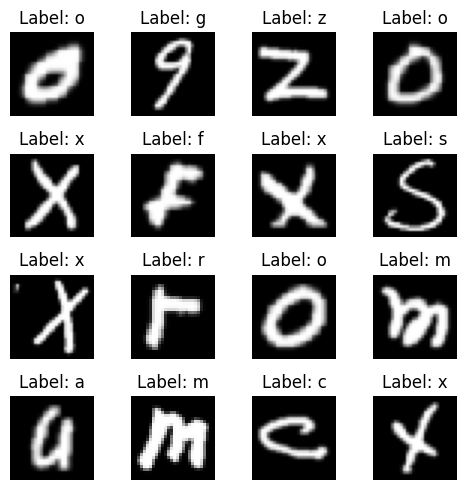

In [4]:
import matplotlib.pyplot as plt

data_loader = DataLoader(train_set, batch_size=16, shuffle=True)
images, labels = next(iter(data_loader))

fig, axes = plt.subplots(4, 4, figsize=(5, 5))

for i, ax in enumerate(axes.flatten()):
    ax.imshow(images[i].squeeze().transpose(0, 1), cmap="gray")
    ax.set_title(f"Label: {train_set.classes[labels[i].item()]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Model

In [20]:
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, ks=5, bn=False, p_dropout=0):
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, ks)
        self.bn = nn.BatchNorm2d(out_channels) if bn else nn.Identity()
        self.pool = nn.AvgPool2d(2, 2)
        self.dropout = nn.Dropout(p=p_dropout) if p_dropout > 0 else nn.Identity()
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.bn(x)
        x = self.pool(x)
        x = self.relu(x)
        x = self.dropout(x)

        return x


class KindaLeNet(nn.Module):
    def __init__(self, n_classes, p_dropout=0, add_batchnorm=False):
        super().__init__()

        self.blocks = nn.ModuleList([
            ConvBlock(in_ch, out_ch, ks, bn=add_batchnorm, p_dropout=p_dropout)
            for (in_ch, out_ch, ks) in [
                (1, 6, 5),
                (6, 18, 5),
                (18, 200, 3),
            ]
        ])

        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, n_classes),
        )
    
    def reset_params(self):
        for block in self.blocks:
            if hasattr(block, "reset_parameters"):
                block.reset_parameters()

        for layer in self.head:
            if hasattr(layer, "reset_parameters"):
                layer.reset_parameters()


    def forward(self, x):
        for block in self.blocks:
            x = block(x)

        x = self.head(x) 

        return x

In [6]:
n_classes = len(train_set.classes)

In [7]:
from torchinfo import summary
model = KindaLeNet(n_classes)

summary(model, input_size=(1024, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
KindaLeNet                               [1024, 27]                --
├─ModuleList: 1-1                        --                        --
│    └─ConvBlock: 2-1                    [1024, 6, 12, 12]         --
│    │    └─Conv2d: 3-1                  [1024, 6, 24, 24]         156
│    │    └─ReLU: 3-2                    [1024, 6, 24, 24]         --
│    │    └─Identity: 3-3                [1024, 6, 24, 24]         --
│    │    └─AvgPool2d: 3-4               [1024, 6, 12, 12]         --
│    │    └─ReLU: 3-5                    [1024, 6, 12, 12]         --
│    │    └─Identity: 3-6                [1024, 6, 12, 12]         --
│    └─ConvBlock: 2-2                    [1024, 18, 4, 4]          --
│    │    └─Conv2d: 3-7                  [1024, 18, 8, 8]          2,718
│    │    └─ReLU: 3-8                    [1024, 18, 8, 8]          --
│    │    └─Identity: 3-9                [1024, 18, 8, 8]          --
│    │    └

## Training

In [8]:
import lightning as L
import torch
from torch import optim
import torchmetrics
from pytorch_lightning.loggers import TensorBoardLogger

In [9]:
train_set_size = int(len(train_set) * 0.8)
valid_set_size = len(train_set) - train_set_size

seed = torch.Generator().manual_seed(42)
train_set, valid_set = torch.utils.data.random_split(train_set, [train_set_size, valid_set_size], generator=seed)

In [16]:
class LitKindaLeNet(L.LightningModule):
    def __init__(self, model_params):
            super().__init__()
            self.model = KindaLeNet(**model_params)
            self.loss_fn = nn.CrossEntropyLoss()
            self.val_acc = torchmetrics.classification.Accuracy(
                 task="multiclass",
                 num_classes=model_params["n_classes"],
            )
            self.test_acc = torchmetrics.classification.Accuracy(
                 task="multiclass",
                 num_classes=model_params["n_classes"],
            )

    def training_step(self, batch, batch_idx):
        x, labels = batch

        logits = self.model(x)

        loss = self.loss_fn(logits, labels)
        self.log("train_loss", loss)

        return loss
    
    def validation_step(self, batch, batch_idx):
        x, labels = batch
        logits = self.model(x)
        val_loss = self.loss_fn(logits, labels)
        self.val_acc(logits, labels)

        self.log("val_loss", val_loss, on_step=False, on_epoch=True)
        self.log("val_acc", self.val_acc, on_step=False, on_epoch=True)
    
    def test_step(self, batch, batch_idx):
        x, labels = batch
        logits = self.model(x)

        self.test_acc(logits, labels)
        self.log("test_acc", self.val_acc, on_step=False, on_epoch=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        scheduler = optim.lr_scheduler.MultiStepLR(
            optimizer,
            milestones=[2000, 3000],
            gamma=0.1,
        ) 

        return {
             "optimizer": optimizer,
             "scheduler": scheduler,
        } 
    

In [ ]:
batch_size = 2048 
model_params = {
    "n_classes": int(len(test_set.classes)),
    "add_batchnorm": False,
    "p_dropout": 0,
}

logger = TensorBoardLogger(
    save_dir=os.getcwd(),
    version="baseline",
)

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=50)
val_loader = DataLoader(valid_set, batch_size=batch_size, num_workers=50)
model = LitKindaLeNet(model_params)

trainer = L.Trainer(accelerator="gpu", max_epochs=150, logger=logger)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)


In [ ]:
batch_size = 2048 
model_params = {
    "n_classes": int(len(test_set.classes)),
    "add_batchnorm": True,
    "p_dropout": 0.2,
}

logger = TensorBoardLogger(
    save_dir=os.getcwd(),
    version="baseline_bn_p0.2",
)

train_loader = DataLoader(train_set, batch_size=batch_size, num_workers=50)
val_loader = DataLoader(valid_set, batch_size=batch_size, num_workers=50)
modelv1 = LitKindaLeNet(model_params)

trainer = L.Trainer(accelerator="gpu", max_epochs=150, logger=logger)
trainer.fit(modelv1, train_dataloaders=train_loader, val_dataloaders=val_loader)


## Results

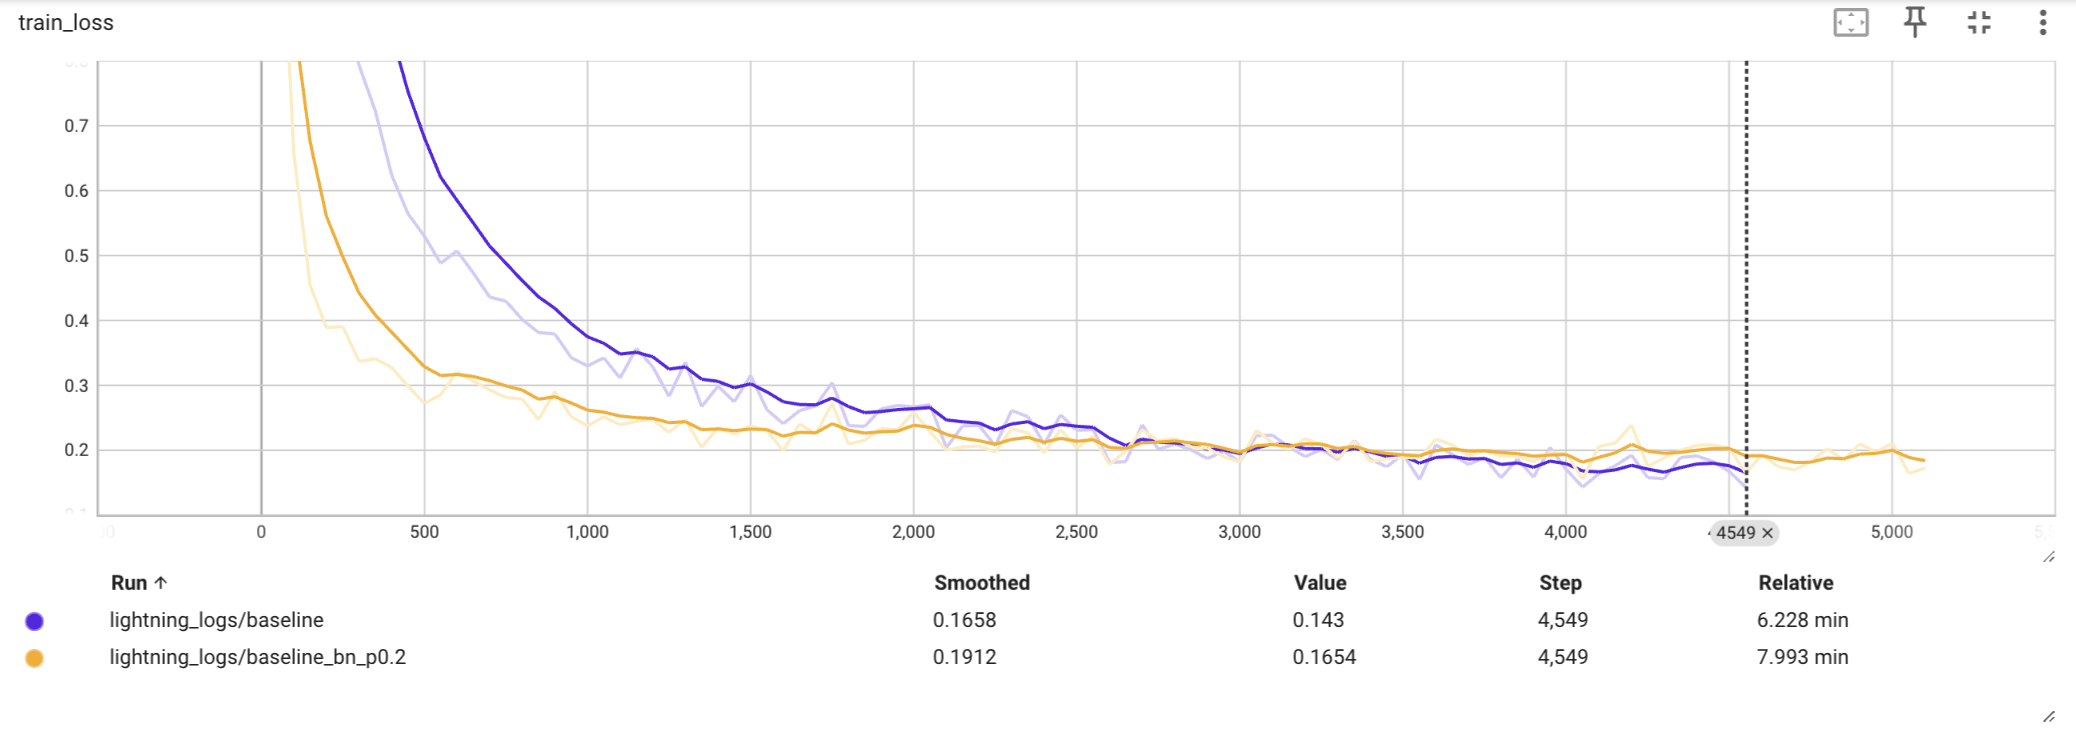

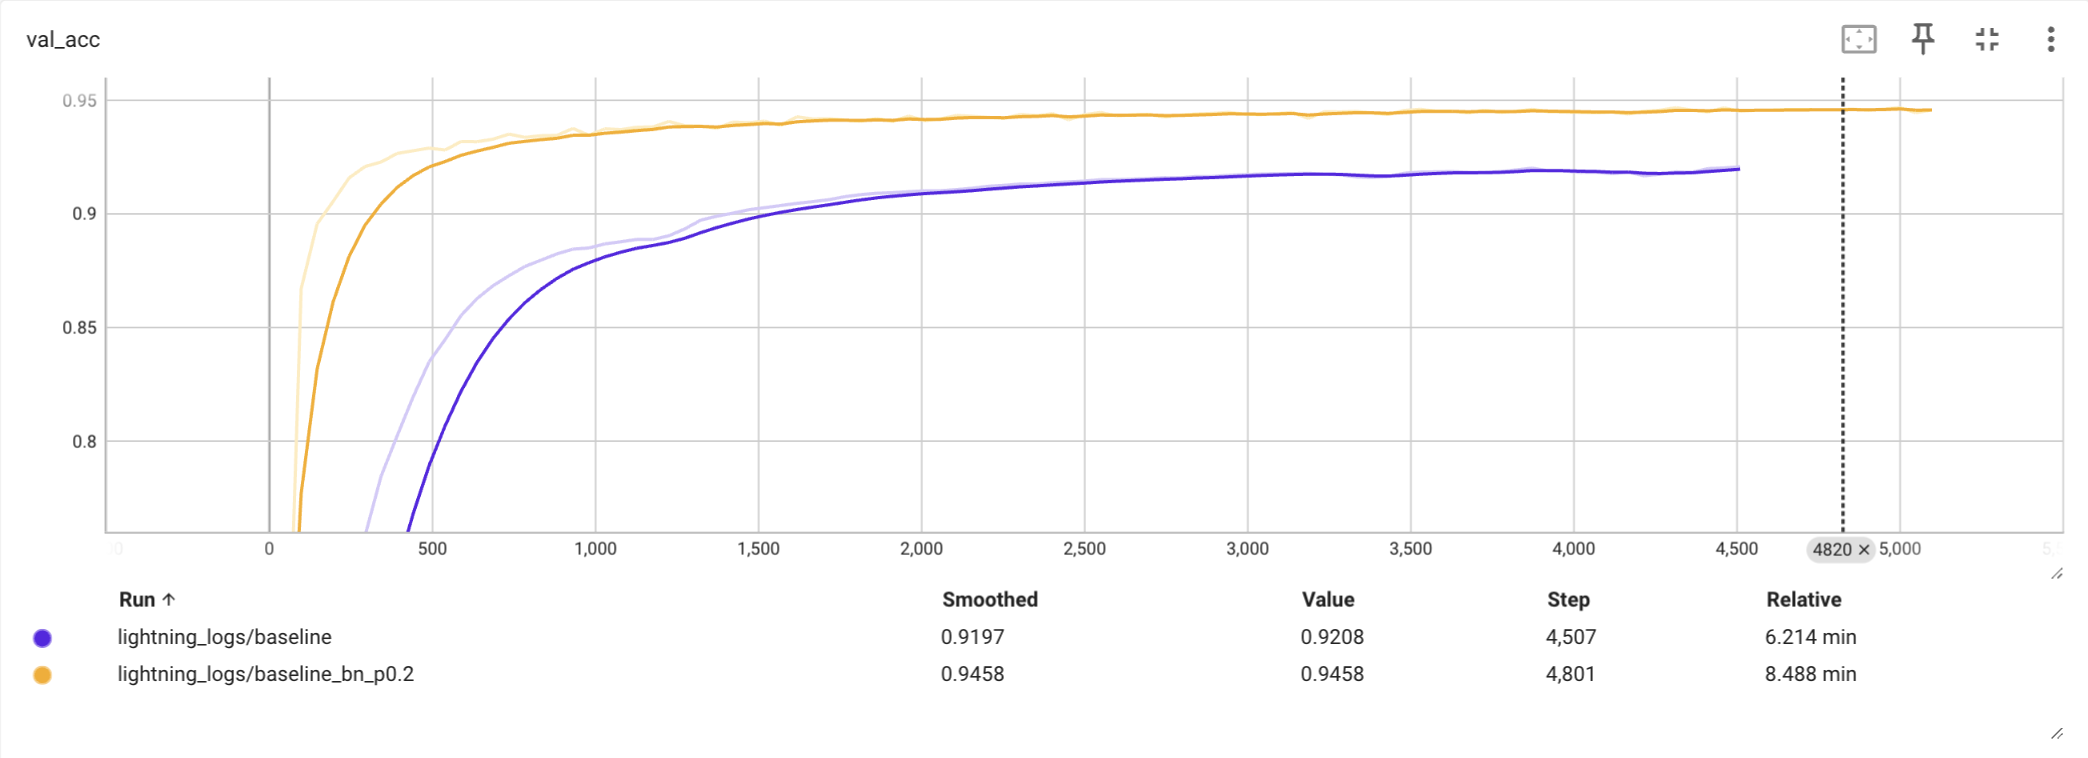